In [134]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# kernel_sizes = (15,15)
kernel_sizes = (0,0)
ksize = kernel_sizes[0] if kernel_sizes[0]!=0 else -1
# Create a 64x64 sample image
image = np.zeros((64, 64, 3), dtype=np.uint8)
image[:, :32] = [0, 0, 0]
image[:, 32:] = [255, 255, 255]
cv2.imwrite('split_image.png', image)
# image = cv2.imread('split_image.png', cv2.IMREAD_GRAYSCALE)

# image = cv2.imread('mandrill.jpg')
# image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


image = cv2.imread('peppers.jpg', cv2.IMREAD_GRAYSCALE)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [135]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def visualize_filters(image, filter):
    sigmas = [1, 2, 4, 8]
    
    plt.figure(figsize=(15, 3))
    
    # Original image
    plt.subplot(151)
    plt.title('Original')
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    
    for j, sigma in enumerate(sigmas):
        
        # Apply Gaussian filter
        filtered = filter(image, sigma)
        
        # Plot
        plt.subplot(1, len(sigmas)+1,  j + 2)
        plt.title(f'σ={sigma}')
        plt.imshow(filtered, cmap='gray')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()



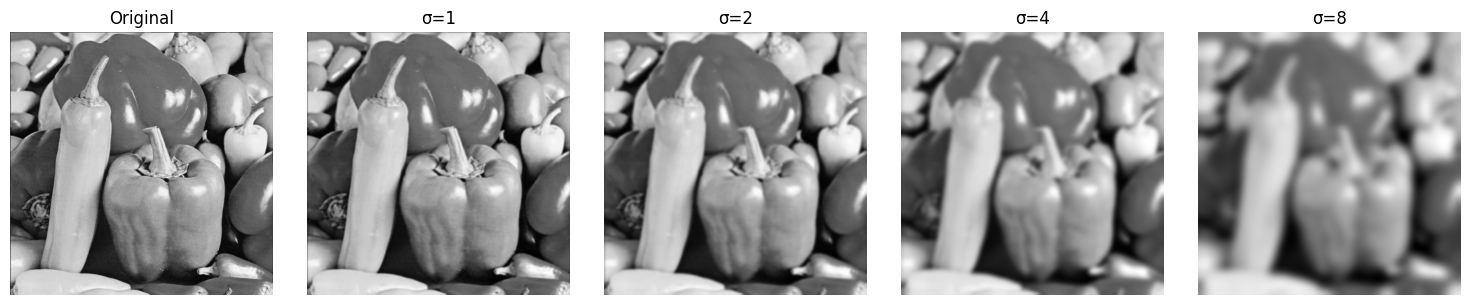

In [136]:
def gaussian_filters(image,sigma):
    return cv2.GaussianBlur(image, (0,0), sigmaX=sigma, sigmaY=sigma)
    
# Run the visualization
visualize_filters(image,gaussian_filters)

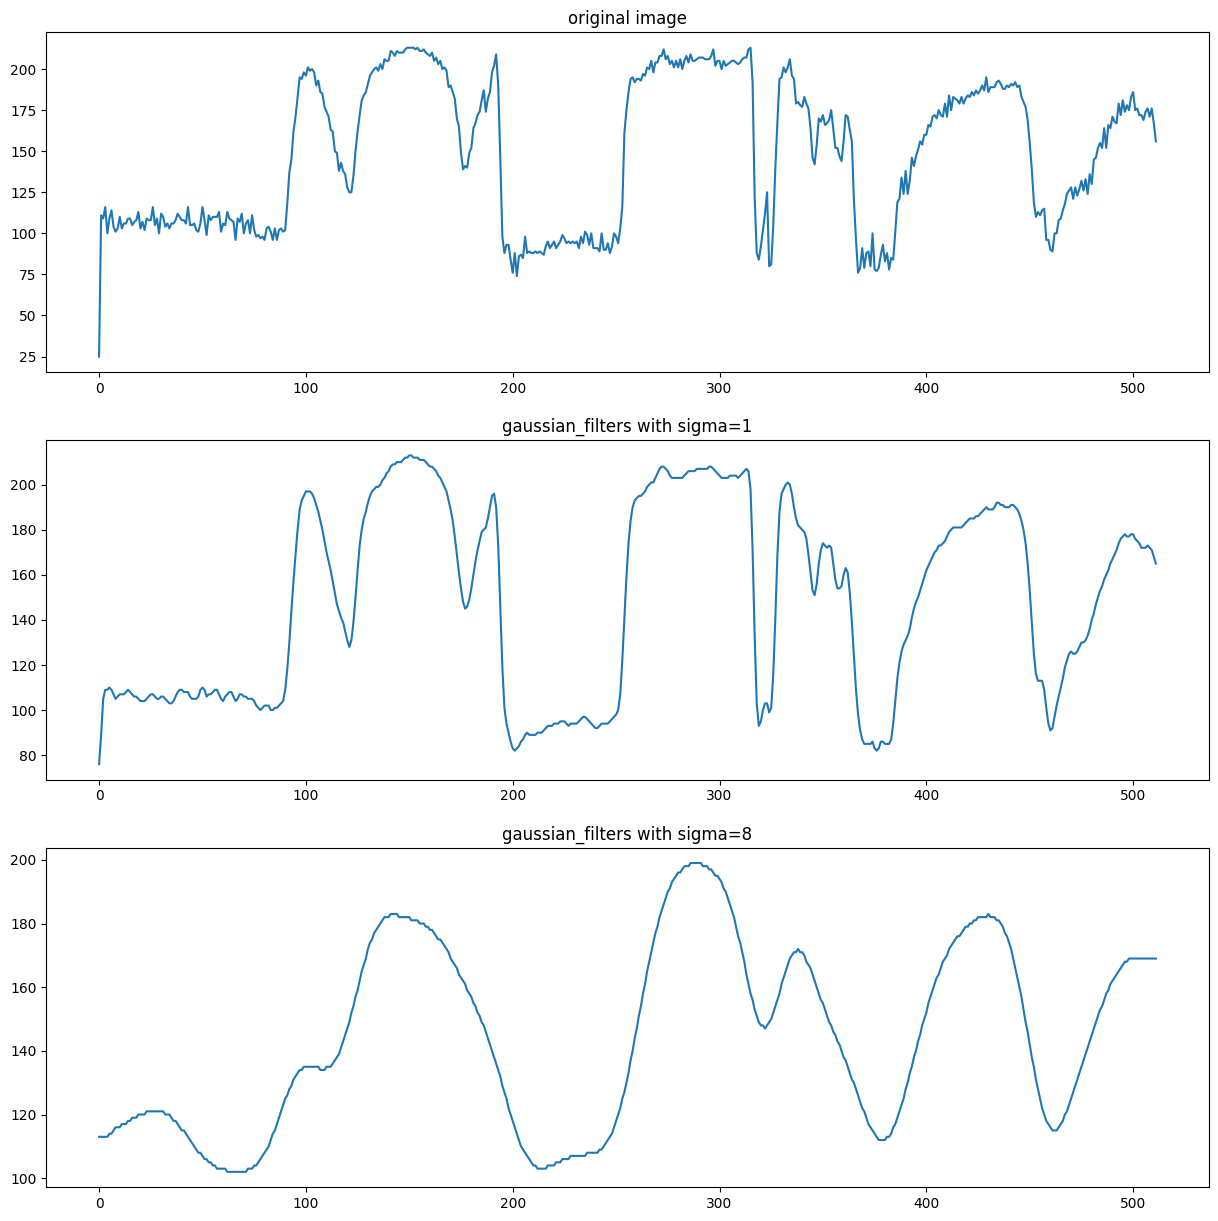

In [138]:

plt.figure(figsize=(15,15))
plt.subplot(3,1,1)
plt.title("original image")
plt.plot(image[10])

plt.subplot(3,1,2)
plt.title("gaussian_filters with sigma=1")
plt.plot(gaussian_filters(image,1)[10])
plt.subplot(3,1,3)

plt.title("gaussian_filters with sigma=8")
plt.plot(gaussian_filters(image,8)[10])


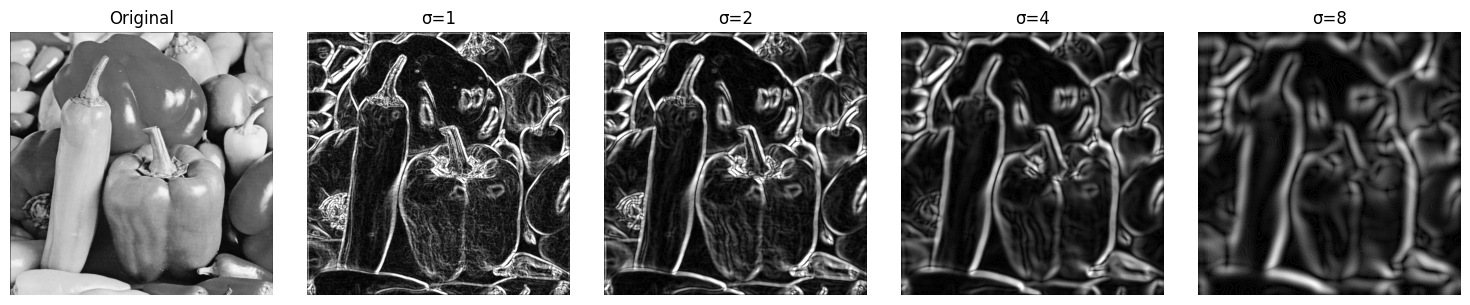

In [142]:
#https://docs.opencv.org/4.x/d2/d2c/tutorial_sobel_derivatives.html
def gradient_magnitudes(image, sigma):
    blurred = cv2.GaussianBlur(image, kernel_sizes, sigma,sigma)
    gradient_x = cv2.Sobel(blurred, cv2.CV_32F, 1, 0, ksize=ksize, borderType=cv2.BORDER_DEFAULT)
    gradient_y = cv2.Sobel(blurred, cv2.CV_32F, 0, 1, ksize=ksize, borderType=cv2.BORDER_DEFAULT)
    
    abs_grad_x = cv2.convertScaleAbs(gradient_x)
    abs_grad_y = cv2.convertScaleAbs(gradient_y)
    
    gradient_magnitude = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
    return gradient_magnitude

visualize_filters(image,gradient_magnitudes)

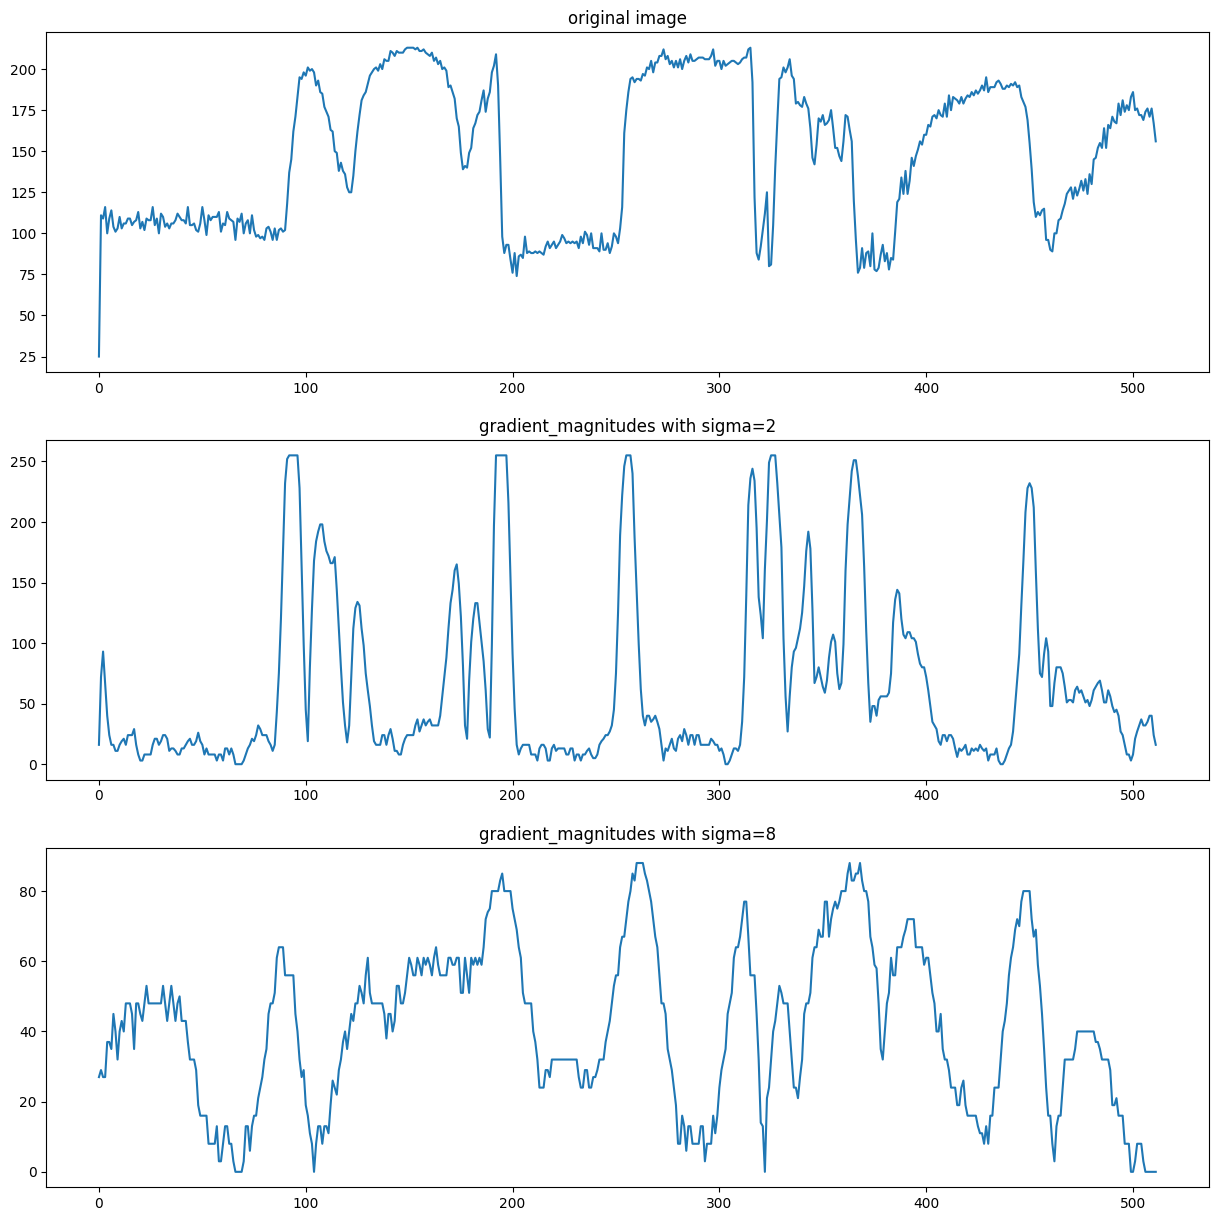

In [143]:

plt.figure(figsize=(15,15))
plt.subplot(3,1,1)
plt.title("original image")
plt.plot(image[10])

plt.subplot(3,1,2)
plt.title("gradient_magnitudes with sigma=2")
plt.plot(gradient_magnitudes(image,2)[10])
plt.subplot(3,1,3)

plt.title("gradient_magnitudes with sigma=8")
plt.plot(gradient_magnitudes(image,8)[10])


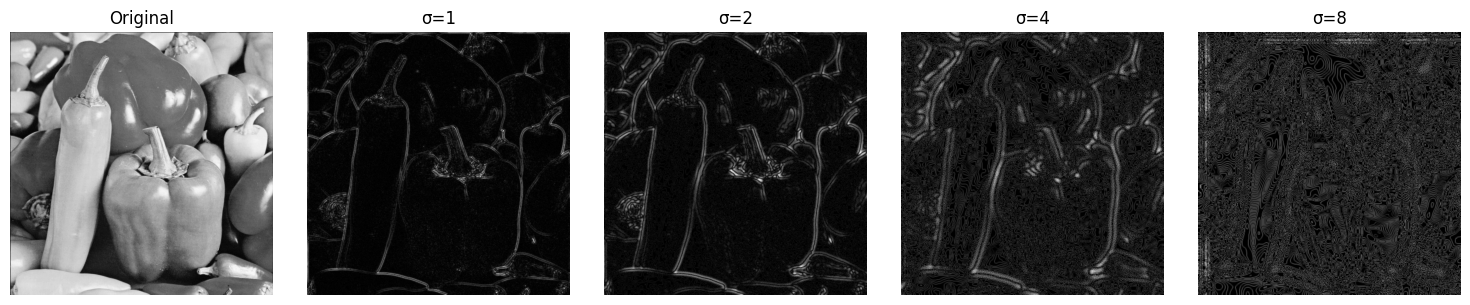

In [171]:
#https://docs.opencv.org/3.4/d5/db5/tutorial_laplace_operator.html

def LoG(image,sigma):
    blur = cv2.GaussianBlur(image, (0, 0), sigma, sigma)
    res = cv2.Laplacian(blur, cv2.CV_32F, ksize=3)
    # res = cv2.Laplacian(blur, cv2.CV_16S)
    res = cv2.convertScaleAbs(res)
    return res
visualize_filters(image,LoG)

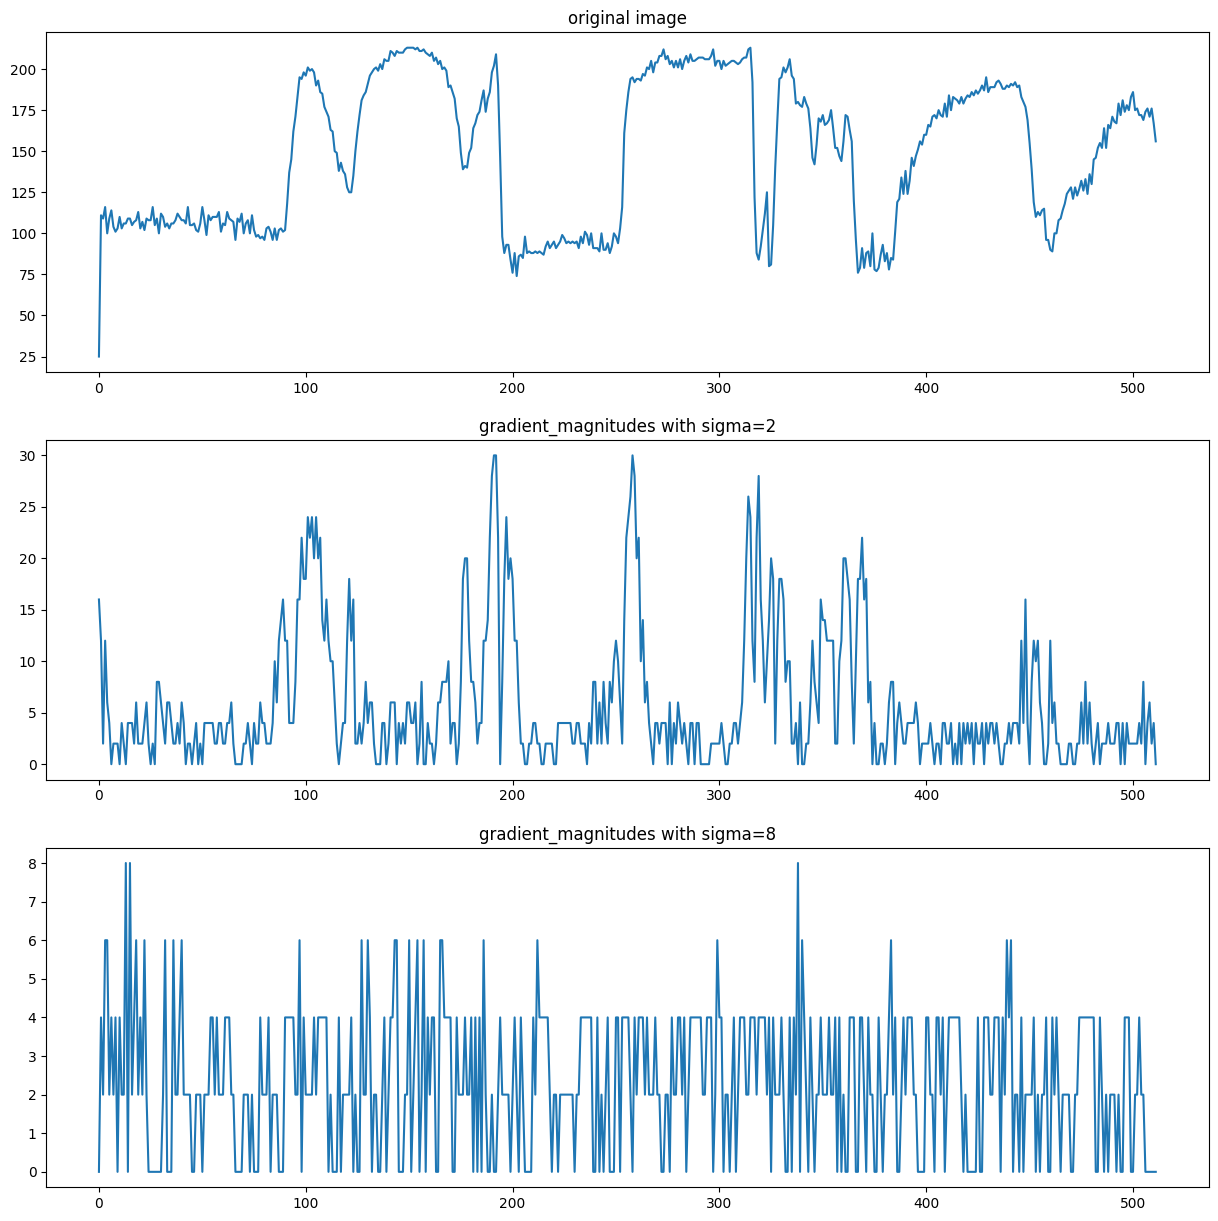

In [172]:

plt.figure(figsize=(15,15))
plt.subplot(3,1,1)
plt.title("original image")
plt.plot(image[10])

plt.subplot(3,1,2)
plt.title("gradient_magnitudes with sigma=2")
plt.plot(LoG(image,2)[10])
plt.subplot(3,1,3)

plt.title("gradient_magnitudes with sigma=8")
plt.plot(LoG(image,8)[10])


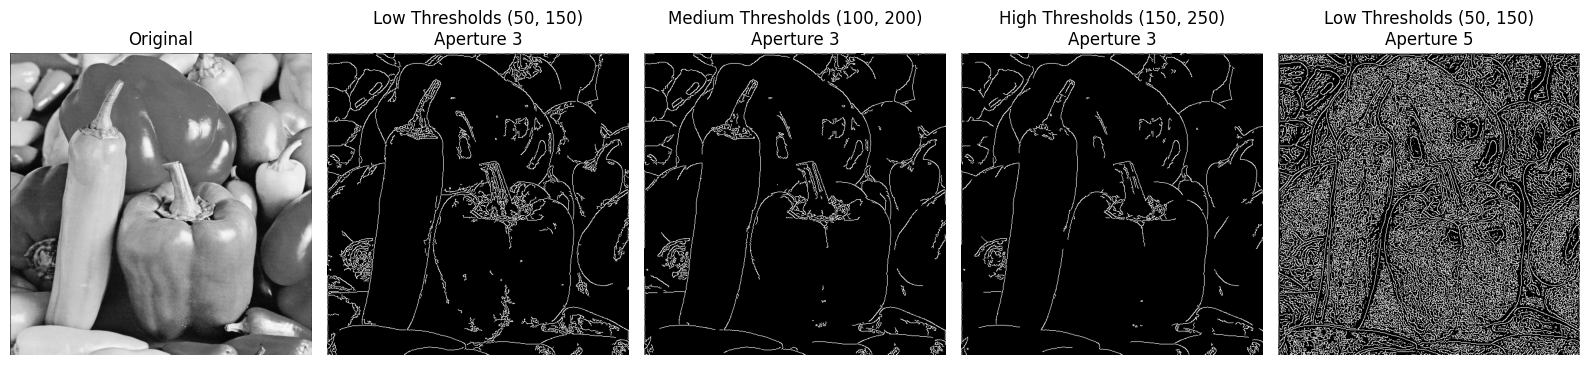

In [179]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def canny_edge_detection(image, low_threshold, high_threshold, aperture_size=3):
    """
    Perform Canny edge detection with configurable parameters
    
    Parameters:
    - low_threshold: Lower threshold for edge detection
    - high_threshold: Higher threshold for edge detection
    - aperture_size: Sobel operator size (3, 5, or 7)
    """
    edges = cv2.Canny(image, 
                      threshold1=low_threshold, 
                      threshold2=high_threshold, 
                      apertureSize=aperture_size)
    return edges

def visualize_canny_parameters(image):
    plt.figure(figsize=(16, 12))
    
    # Parameter combinations
    params = [
        (50, 150, 3),   # Low sensitivity
        (100, 200, 3),  # Medium sensitivity
        (150, 250, 3),  # High sensitivity
        (50, 150, 5),   # Larger aperture size
    ]
    
    titles = [
        'Low Thresholds (50, 150)\nAperture 3',
        'Medium Thresholds (100, 200)\nAperture 3', 
        'High Thresholds (150, 250)\nAperture 3',
        'Low Thresholds (50, 150)\nAperture 5'
    ]
    
    # Original image
    plt.subplot(1, 5, 1)
    plt.title('Original')
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    
    # Canny edge detection with different parameters
    for i, (low, high, aperture) in enumerate(params, 2):
        edges = canny_edge_detection(image, low, high, aperture)
        
        plt.subplot(1, 5, i)
        plt.title(titles[i-2])
        plt.imshow(edges, cmap='gray')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
visualize_canny_parameters(image)
